In [1]:
# Install dan import library
!pip install -q tensorflow torchvision scikit-learn matplotlib

import torch
import torchvision
import torchvision.transforms as transforms
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 833.5 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 62.2 MB/s eta 0:00:00


In [2]:
#pytorch
# Transformasi dan normalisasi
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

trainset_pt = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset_pt = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainloader_pt = torch.utils.data.DataLoader(trainset_pt, batch_size=64, shuffle=True)
testloader_pt = torch.utils.data.DataLoader(testset_pt, batch_size=64, shuffle=False)


100%|██████████| 170M/170M [00:02<00:00, 79.3MB/s]


In [3]:
#tensorflow
(ds_train_tf, ds_test_tf), ds_info = tfds.load('cifar10', split=['train', 'test'], shuffle_files=True,
                                               as_supervised=True, with_info=True)

# Normalisasi dan Augmentasi
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

def augment(image, label):
    # Ensure image is float32 before augmentation
    image = tf.cast(image, tf.float32) / 255.0
    return data_augmentation(image), label

def normalize_img(image, label):
    return tf.cast(image, tf.float32) / 255.0, label

# Apply normalization first, then augment, then batch and prefetch
ds_train_tf = ds_train_tf.map(normalize_img).map(augment).cache().shuffle(1000).batch(64).prefetch(tf.data.AUTOTUNE)
ds_test_tf = ds_test_tf.map(normalize_img).batch(64).cache().prefetch(tf.data.AUTOTUNE)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/incomplete.CCUASU_3.0.2/cifar10-train.tfrecord*...:   0%|         …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/incomplete.CCUASU_3.0.2/cifar10-test.tfrecord*...:   0%|          …

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


In [4]:
#model MLP tensorflow
mlp_tf = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(32, 32, 3)),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

mlp_tf.compile(optimizer='adam',
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])

mlp_tf.fit(ds_train_tf, epochs=10, validation_data=ds_test_tf)


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


782/782 ━━━━━━━━━━━━━━━━━━━━ 50s 61ms/step - accuracy: 0.1992 - loss: 2.1246 - val_accuracy: 0.1816 - val_loss: 250.1911
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 46s 16ms/step - accuracy: 0.3117 - loss: 1.9080 - val_accuracy: 0.2317 - val_loss: 250.7554
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.3410 - loss: 1.8352 - val_accuracy: 0.2410 - val_loss: 268.1065
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.3578 - loss: 1.7869 - val_accuracy: 0.2530 - val_loss: 268.8858
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.3695 - loss: 1.7503 - val_accuracy: 0.2593 - val_loss: 285.9630
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.3810 - loss: 1.7176 - val_accuracy: 0.2694 - val_loss: 278.2210
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.3968 - loss: 1.6855 - val_accuracy: 0.2783 - val_loss: 275.9268
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.4035 - loss: 1.6658

In [5]:
#model CNN Tensorflow
cnn_tf = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation='softmax')
])


cnn_tf.compile(optimizer='adam',
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])

cnn_tf.fit(ds_train_tf, epochs=10, validation_data=ds_test_tf)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


782/782 ━━━━━━━━━━━━━━━━━━━━ 998s 1s/step - accuracy: 0.3529 - loss: 2.0583 - val_accuracy: 0.1408 - val_loss: 1035.4231
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 1014s 1s/step - accuracy: 0.5395 - loss: 1.3140 - val_accuracy: 0.1824 - val_loss: 397.4935
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 987s 1s/step - accuracy: 0.5979 - loss: 1.1424 - val_accuracy: 0.1188 - val_loss: 359.2929
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 951s 1s/step - accuracy: 0.6431 - loss: 1.0157 - val_accuracy: 0.1817 - val_loss: 283.9725
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 954s 1s/step - accuracy: 0.6723 - loss: 0.9375 - val_accuracy: 0.1741 - val_loss: 262.3608
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 950s 1s/step - accuracy: 0.7019 - loss: 0.8509 - val_accuracy: 0.1968 - val_loss: 171.5565
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 983s 1s/step - accuracy: 0.7284 - loss: 0.7719 - val_accuracy: 0.1903 - val_loss: 150.4003
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 1003s 1s/step - accuracy: 0.7585 - loss: 0.7037 - va

In [6]:
#model CNN PyTorch
import torch.nn as nn
import torch.nn.functional as F
class CNN_PT(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.fc1 = nn.Linear(64 * 6 * 6, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 6 * 6)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Check if CUDA is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn_pt = CNN_PT().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn_pt.parameters(), lr=0.001)

for epoch in range(10):
    cnn_pt.train()
    running_loss = 0.0
    for images, labels in trainloader_pt:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = cnn_pt(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1} Loss: {running_loss/len(trainloader_pt)}")

Epoch 1 Loss: 1.4657361216252418
Epoch 2 Loss: 1.1142620366552602
Epoch 3 Loss: 0.9655817037500689
Epoch 4 Loss: 0.8634430349178022
Epoch 5 Loss: 0.7846825731456127
Epoch 6 Loss: 0.7225418485643919
Epoch 7 Loss: 0.6689921381223537
Epoch 8 Loss: 0.6164916031195989
Epoch 9 Loss: 0.5768350136020909
Epoch 10 Loss: 0.5340039045228373


In [7]:
#model CNN PyTorch


class CNN_PT(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.fc1 = nn.Linear(64 * 6 * 6, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 6 * 6) # Reshape for the fully connected layer
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Check if CUDA is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn_pt = CNN_PT().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn_pt.parameters(), lr=0.001)

for epoch in range(10):
    cnn_pt.train()
    running_loss = 0.0
    for images, labels in trainloader_pt:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = cnn_pt(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1} Loss: {running_loss/len(trainloader_pt)}")

Epoch 1 Loss: 1.4630194773606937
Epoch 2 Loss: 1.1036926095595445
Epoch 3 Loss: 0.9561078152845582
Epoch 4 Loss: 0.8621587722807589
Epoch 5 Loss: 0.7995844785972019
Epoch 6 Loss: 0.7382338207472315
Epoch 7 Loss: 0.6853236564056343
Epoch 8 Loss: 0.6393411705637222
Epoch 9 Loss: 0.5986547960573451
Epoch 10 Loss: 0.5568273036604952


In [8]:
#evaluasi
def evaluate_model_tf(model, dataset):
    y_true, y_pred = [], []
    for x, y in dataset:
        preds = model.predict(x)
        y_true.extend(y.numpy())
        y_pred.extend(np.argmax(preds, axis=1))
    return y_true, y_pred

def evaluate_model_pt(model, dataloader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.cuda(), y.cuda()
            outputs = model(x)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(y.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    return y_true, y_pred


In [9]:
#hitung metrik
def print_metrics(y_true, y_pred, average='macro'):
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred, average=average))
    print("Recall:", recall_score(y_true, y_pred, average=average))
    print("F1 Score:", f1_score(y_true, y_pred, average=average))


In [10]:
# Tambahkan return dari history saat training
history_cnn = cnn_tf.fit(ds_train_tf, epochs=10, validation_data=ds_test_tf)


Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 943s 1s/step - accuracy: 0.8150 - loss: 0.5183 - val_accuracy: 0.1985 - val_loss: 193.7742
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 947s 1s/step - accuracy: 0.8303 - loss: 0.4803 - val_accuracy: 0.3366 - val_loss: 81.2101
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 1025s 1s/step - accuracy: 0.8208 - loss: 0.5125 - val_accuracy: 0.2993 - val_loss: 109.4022
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 940s 1s/step - accuracy: 0.8572 - loss: 0.4036 - val_accuracy: 0.2424 - val_loss: 190.0094
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 976s 1s/step - accuracy: 0.8738 - loss: 0.3596 - val_accuracy: 0.2923 - val_loss: 149.7304
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 946s 1s/step - accuracy: 0.8735 - loss: 0.3492 - val_accuracy: 0.3066 - val_loss: 134.0332
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 937s 1s/step - accuracy: 0.8866 - loss: 0.3205 - val_accuracy: 0.3857 - val_loss: 99.9014
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 1022s 1s/step - accuracy: 0.8947 - loss: 0.2

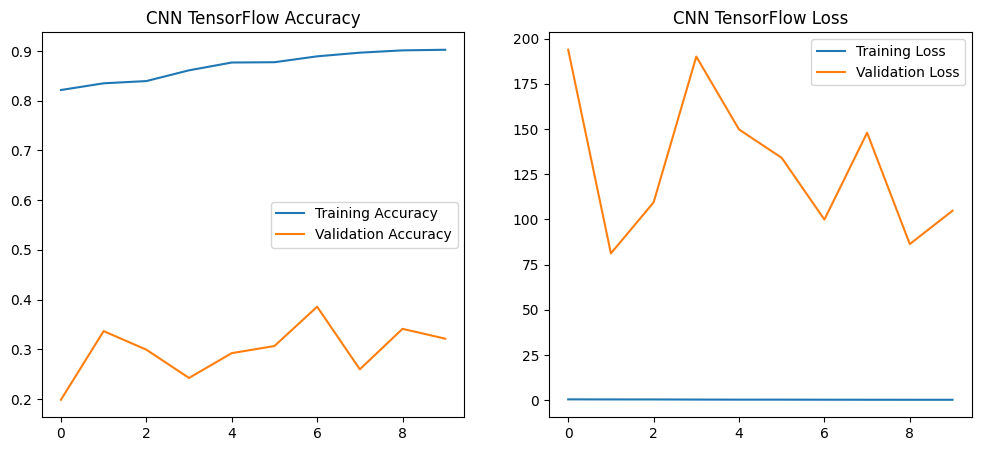

In [11]:
# Grafik Akurasi dan Loss
def plot_training_history(history, title='CNN'):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend()
    plt.title(f'{title} Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend()
    plt.title(f'{title} Loss')
    plt.show()

plot_training_history(history_cnn, 'CNN TensorFlow')


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 274ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 251ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 

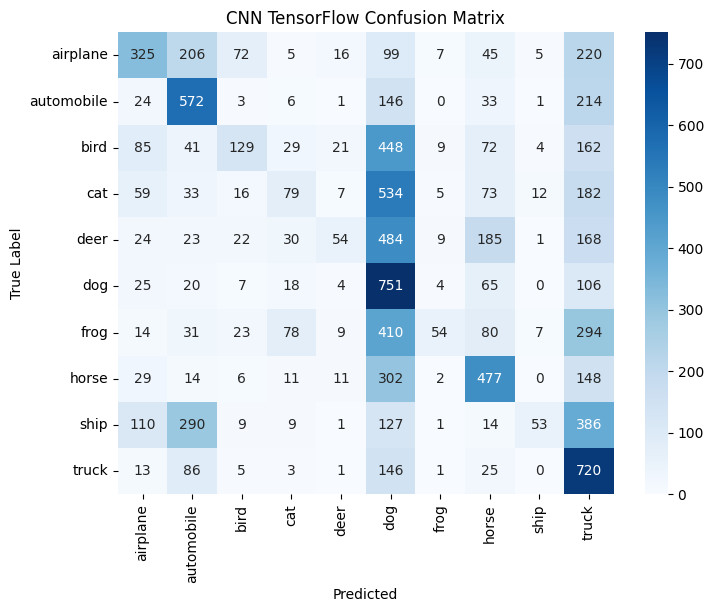

In [12]:
#confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, class_names, title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True Label')
    plt.title(title)
    plt.show()

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']


y_true_tf, y_pred_tf = evaluate_model_tf(cnn_tf, ds_test_tf)
plot_confusion_matrix(y_true_tf, y_pred_tf, class_names, title='CNN TensorFlow Confusion Matrix')


157/157 ━━━━━━━━━━━━━━━━━━━━ 43s 275ms/step


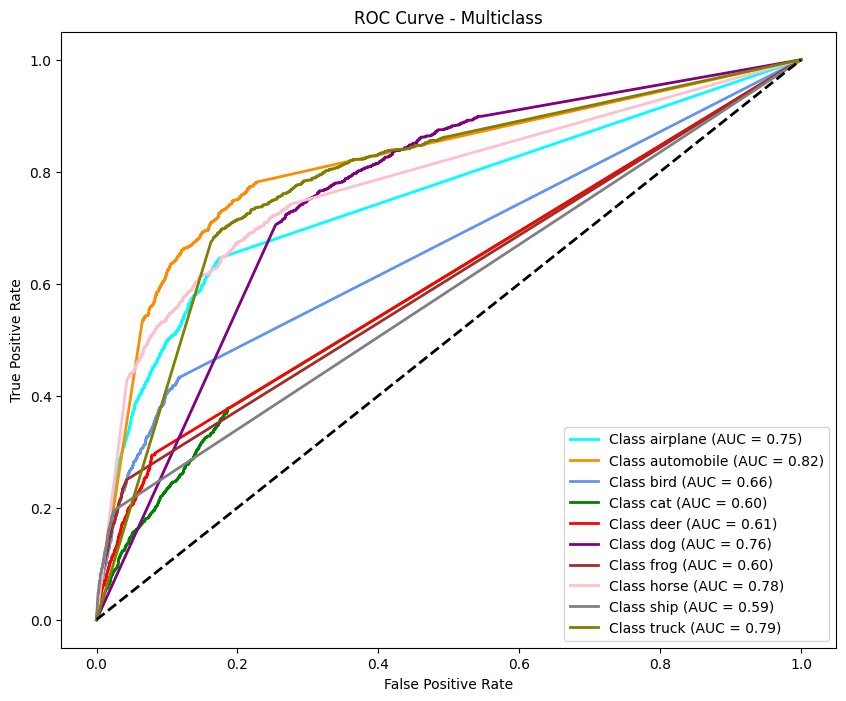

In [13]:
#ROC per kelas
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle

def plot_roc_multiclass(y_true, y_score, n_classes=10):
    # One-hot encoding label
    y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive'])
    plt.figure(figsize=(10, 8))
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='Class {0} (AUC = {1:0.2f})'.format(class_names[i], roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - Multiclass')
    plt.legend(loc='lower right')
    plt.show()

# Skor probabilitas
y_score_tf = cnn_tf.predict(ds_test_tf)
plot_roc_multiclass(y_true_tf, y_score_tf)


## Penjelasan Persamaan Matematika untuk Metrik Evaluasi

**1. Akurasi**
\[
\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}
\]
Mengukur proporsi prediksi yang benar dari seluruh data.

**2. Presisi**
\[
\text{Precision} = \frac{TP}{TP + FP}
\]
Mengukur seberapa tepat model saat memprediksi kelas positif.

**3. Recall**
\[
\text{Recall} = \frac{TP}{TP + FN}
\]
Mengukur seberapa baik model menemukan semua data positif.

**4. F1 Score**
\[
\text{F1} = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}
\]
Rata-rata harmonik dari presisi dan recall.

**5. AUC (Area Under Curve)** dan **ROC (Receiver Operating Characteristic Curve)**  
AUC mengukur luas di bawah kurva ROC yang merepresentasikan trade-off antara True Positive Rate dan False Positive Rate.
